In [1]:
import re
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GroupKFold
import shap
from datetime import datetime
import sglearn
from sklearn.model_selection import train_test_split
import pandas as pd
import gpplot
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from rs3.seq import predict_seq

In [4]:
train_data = pd.read_csv('../../data/2022/rs_dev_all_sgrnas.csv')

In [5]:

horlbeck_2016_sept = pd.read_csv('../../data/2022/horlbeck_2016_sept/horlbeck2016_sept_activity.csv')
sanson_2018 = pd.read_csv('../../data/2022/sanson_2018/sanson2018_activity.csv')

During the first iteration, I trained on the largest dataset, Gilbert et al 2014. This dataset has 11835 sgRNA targeting essential genes which makes up 69% of the total training data. Since multiple datasets could introduce heterogeneity, I first used the result for one dataset to perserve homogeneity.

In Gilbert et al 2014, gamma is used instead of LFC to measure observe activity. Gamma is normalized log2 of the cell fraction to the median log2 of the negative control set and then divided by t (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4253859/#SD5). I further normliazed gamma to an average mean centered negative. In the following anaysis, I denote **average mean centered negative gamma as observed activity**. 

# Compare RS3 Chen seq score and RS3 Hsu seq score with the observed activity 

In [7]:
gilbert2014_rs3 = pd.read_csv('../../data/2022/gilbert_2014/gilbert2014_activity.csv')
gilbert2014_rs3 = gilbert2014_rs3.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)

In [8]:
gilbert2014_rs3.head()

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Chen On-Target Efficacy Score,sgRNA 'Cut' Site TSS Offset,DHS Score,Off-Target Rank,Pick Order,avg_rank,avg_mean_centered_neg_gamma,avg_zscore_neg_gamma,avg_median_centered_neg_gamma,avg_robust_zscore_neg_gamma,avg_gamma
0,AAAAACCGTCAGTAACACCG,ACAGAAAAACCGTCAGTAACACCGAGGACA,DPH5,0.22540,281,1.0,14,26.0,0.800000,0.006335,0.231827,0.010429,0.469227,-0.023441
1,AAAAAGGAGGTGTCCGGGTA,GAGGAAAAAGGAGGTGTCCGGGTAGGGCAA,NAA15,-0.12330,121,0.0,38,53.0,0.200000,-0.032686,-0.502020,-0.012122,-0.330041,0.011355
2,AAAAATGGCAGCCGCCGCTC,GCAGAAAAATGGCAGCCGCCGCTCCGGACT,RRP15,0.03283,36,1.0,35,3.0,1.000000,0.054083,2.379131,0.059402,3.813684,-0.068108
3,AAAAGCCGCAGGTAGGAGCA,CTCGAAAAGCCGCAGGTAGGAGCAAGGATC,RPAP2,0.08538,93,0.0,72,12.0,0.300000,-0.212684,-0.886969,-0.093857,-0.217992,-0.001776
4,AAAAGGGGCGCGGTGAGCTA,CTGGAAAAGGGGCGCGGTGAGCTAGGGCGG,CSNK1A1,0.65740,155,0.0,19,36.0,0.555556,-0.016589,-0.397251,0.000000,0.000000,-0.007086


In [9]:
gilbert2014_rs3 = gilbert2014_rs3[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_mean_centered_neg_gamma']]

In [10]:
gilbert2014_rs3['Hsu On-Target Efficacy Score'] = predict_seq(gilbert2014_rs3['sgRNA Context Sequence'], sequence_tracr='Hsu2013')


Calculating sequence-based features


100%|████████████████████████████████████| 10601/10601 [00:33<00:00, 317.53it/s]


**Pearson correlation is on the upper left and spearman correlation is on the lower right.** The two graphs below show Chen On-Target Seq Score has a slightly better correlation than Hsu On-Target Seq Score. So I calcualted residual using the difference between observed activity and Chen On-Target Seq Score. 

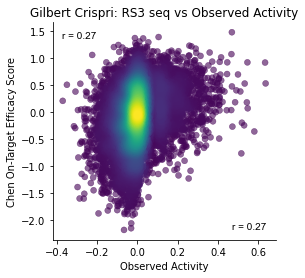

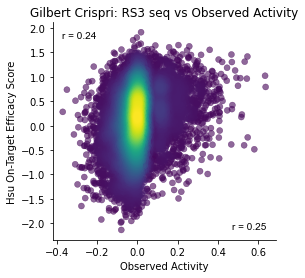

In [11]:
x_axis = 'avg_mean_centered_neg_gamma'
x_axis_name = 'Observed Activity'

for score in ['Chen On-Target Efficacy Score','Hsu On-Target Efficacy Score']:
    plt.subplots(figsize=(4,4))
    gpplot.point_densityplot(data=gilbert2014_rs3[[score, x_axis]].dropna(),
                             y=score, x=x_axis)
    gpplot.add_correlation(data=gilbert2014_rs3[[score, x_axis]].dropna(),
                           y=score, x=x_axis)
    gpplot.add_correlation(data=gilbert2014_rs3[[score, x_axis]].dropna(),
                            y=score, x=x_axis, method='spearman', loc='lower right')
    plt.xlabel(x_axis_name)
    plt.title("Gilbert Crispri: RS3 seq vs Observed Activity")
#    plt.title(score)
    sns.despine()
    # binned by tss and fraction of active (0.15), as a function of tss ( what fraction are active)

Chen On-Target Seq Score and Hsu On-Target Seq Score are well correlated

Text(0.5, 1.0, 'RS3 seq (Hsu) vs RS3 seq (Chen)')

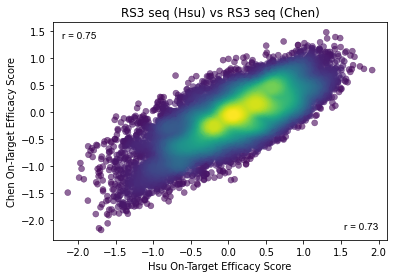

In [12]:
gpplot.point_densityplot(data=gilbert2014_rs3.dropna(),
                             y='Chen On-Target Efficacy Score', 
                         x='Hsu On-Target Efficacy Score')
gpplot.add_correlation(data=gilbert2014_rs3.dropna(),
                             y='Chen On-Target Efficacy Score', 
                         x='Hsu On-Target Efficacy Score')
gpplot.add_correlation(data=gilbert2014_rs3.dropna(),
                             y='Chen On-Target Efficacy Score', 
                         x='Hsu On-Target Efficacy Score', method='spearman', loc='lower right')
plt.title("RS3 seq (Hsu) vs RS3 seq (Chen)")


# Train Crispri model: residual regress on TSS

In [13]:
gilbert2014_rs3['Residual'] = gilbert2014_rs3['avg_mean_centered_neg_gamma']-gilbert2014_rs3['Chen On-Target Efficacy Score']

In [14]:
X = gilbert2014_rs3[['sgRNA \'Cut\' Site TSS Offset', 'sgRNA Context Sequence']]
X = X.set_index('sgRNA Context Sequence')        

In [15]:
X_train, X_val, y_train, y_val = \
    train_test_split(X, gilbert2014_rs3['Residual'], test_size=0.20, random_state=1)
model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=500,
                              num_leaves=10,
                              min_child_samples=100)

In [16]:
print(X_train)

                                sgRNA 'Cut' Site TSS Offset
sgRNA Context Sequence                                     
GAAGCCCATTAGCCGGGGCGCCTTCGGGAA                          197
GGGGCTGGAGCTCTTGTCGGACCAGGGCTA                           82
TCAGACGGCTACTACCCGCATCCCGGGACT                          251
GGAGGAATCCGAAGAAGCGGCCTGTGGCAG                          113
TCCGCTTCGGGGAGGAGGACGCTGAGGAGG                           31
...                                                     ...
AACCCGCCCGGACGTACCGGTGTCTGGACC                           17
GCGGGGGAGGCTACTGCGCATGTCTGGAGG                           -7
AGGGAGCCGCAGTCGCCTCAGATCCGGTCG                           99
CCAGGCAATAGCCAGGGCGCCCCGAGGCAC                          191
CCGGAAGCGGGCGACGCGAAACGACGGCGC                          197

[8480 rows x 1 columns]


In [17]:
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, min_child_samples=100, n_estimators=500,
              n_jobs=1, num_leaves=10, random_state=7)

In [18]:
print("Test Accuracy: %0.2f" % model.score(X_val, y_val))

Test Accuracy: -0.01


In [19]:
X_val['Crispri Target Score'] = model.predict(X_val)


In [20]:
X_val.reset_index(inplace=True)

In [21]:
X_val_pre_y = pd.merge(gilbert2014_rs3, X_val, on = 'sgRNA Context Sequence')

In [22]:
X_val_pre_y['Crispri Sequence + Target Score'] = X_val_pre_y['Chen On-Target Efficacy Score'] + X_val_pre_y['Crispri Target Score']

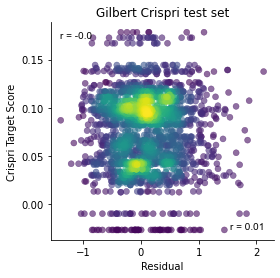

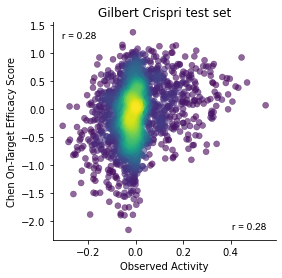

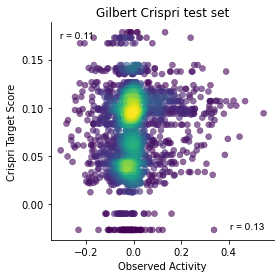

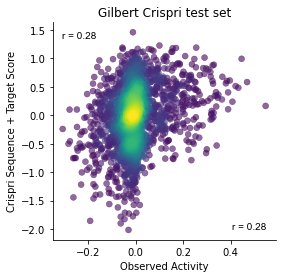

In [23]:

for x_axis in ['Residual','avg_mean_centered_neg_gamma']:
    if x_axis == 'Residual':
        scores = ['Crispri Target Score']
        x_axis_name = 'Residual'
    else:
        scores = ['Chen On-Target Efficacy Score','Crispri Target Score', 'Crispri Sequence + Target Score']
        x_axis_name = 'Observed Activity'
    for score in scores:
        plt.subplots(figsize=(4,4))
        gpplot.point_densityplot(data=X_val_pre_y[[score, x_axis]].dropna(),
                                 y=score, x=x_axis)
        gpplot.add_correlation(data=X_val_pre_y[[score, x_axis]].dropna(),
                               y=score, x=x_axis)
        gpplot.add_correlation(data=X_val_pre_y[[score, x_axis]].dropna(),
                                y=score, x=x_axis, method='spearman', loc='lower right')
        plt.xlabel(x_axis_name)
        plt.title("Gilbert Crispri test set")
    #    plt.title(score)
        sns.despine()
        


# Train Crispri model: residual regress on (TSS + Seq Feature information)

In [24]:
X = sglearn.featurize_guides(gilbert2014_rs3['sgRNA Context Sequence'])


100%|████████████████████████████████████| 10601/10601 [00:39<00:00, 265.21it/s]


In [25]:
X['sgRNA \'Cut\' Site TSS Offset'] = (gilbert2014_rs3['sgRNA \'Cut\' Site TSS Offset']
                               .astype(int)
                               .to_list())

In [26]:
X_train, X_val, y_train, y_val = \
    train_test_split(X, gilbert2014_rs3['Residual'], test_size=0.20, random_state=1)
model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=500,
                              num_leaves=10,
                              min_child_samples=100)

In [27]:
list(X_train.columns)

['GC content',
 'A',
 'C',
 'T',
 'G',
 'AA',
 'AC',
 'AT',
 'AG',
 'CA',
 'CC',
 'CT',
 'CG',
 'TA',
 'TC',
 'TT',
 'TG',
 'GA',
 'GC',
 'GT',
 'GG',
 '-4A',
 '-4C',
 '-4T',
 '-4G',
 '-3A',
 '-3C',
 '-3T',
 '-3G',
 '-2A',
 '-2C',
 '-2T',
 '-2G',
 '-1A',
 '-1C',
 '-1T',
 '-1G',
 '1A',
 '1C',
 '1T',
 '1G',
 '2A',
 '2C',
 '2T',
 '2G',
 '3A',
 '3C',
 '3T',
 '3G',
 '4A',
 '4C',
 '4T',
 '4G',
 '5A',
 '5C',
 '5T',
 '5G',
 '6A',
 '6C',
 '6T',
 '6G',
 '7A',
 '7C',
 '7T',
 '7G',
 '8A',
 '8C',
 '8T',
 '8G',
 '9A',
 '9C',
 '9T',
 '9G',
 '10A',
 '10C',
 '10T',
 '10G',
 '11A',
 '11C',
 '11T',
 '11G',
 '12A',
 '12C',
 '12T',
 '12G',
 '13A',
 '13C',
 '13T',
 '13G',
 '14A',
 '14C',
 '14T',
 '14G',
 '15A',
 '15C',
 '15T',
 '15G',
 '16A',
 '16C',
 '16T',
 '16G',
 '17A',
 '17C',
 '17T',
 '17G',
 '18A',
 '18C',
 '18T',
 '18G',
 '19A',
 '19C',
 '19T',
 '19G',
 '20A',
 '20C',
 '20T',
 '20G',
 'P1A',
 'P1C',
 'P1T',
 'P1G',
 'P2A',
 'P2C',
 'P2T',
 'P2G',
 'P3A',
 'P3C',
 'P3T',
 'P3G',
 '+1A',
 '+1C',
 '+1T

In [28]:
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, min_child_samples=100, n_estimators=500,
              n_jobs=1, num_leaves=10, random_state=7)

In [29]:
print("Test Accuracy: %0.2f" % model.score(X_val, y_val))

Test Accuracy: 0.65


In [30]:
X_val['Crispri Target Score'] = model.predict(X_val)

In [31]:
X_val.reset_index(inplace=True)
X_val_pre_y = pd.merge(gilbert2014_rs3, X_val, on = 'sgRNA Context Sequence')
X_val_pre_y['Crispri Sequence + Target Score'] = X_val_pre_y['Chen On-Target Efficacy Score'] + X_val_pre_y['Crispri Target Score']


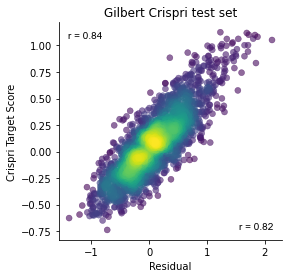

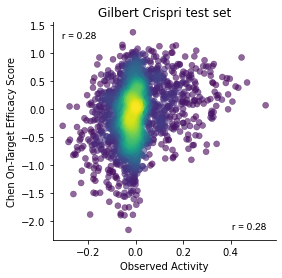

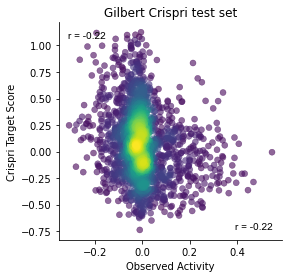

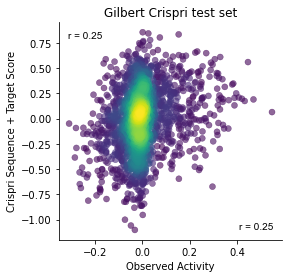

In [32]:
for x_axis in ['Residual','avg_mean_centered_neg_gamma']:
    if x_axis == 'Residual':
        scores = ['Crispri Target Score']
        x_axis_name = 'Residual'
    else:
        scores = ['Chen On-Target Efficacy Score','Crispri Target Score', 'Crispri Sequence + Target Score']
        x_axis_name = 'Observed Activity'
    for score in scores:
        plt.subplots(figsize=(4,4))
        gpplot.point_densityplot(data=X_val_pre_y[[score, x_axis]].dropna(),
                                 y=score, x=x_axis)
        gpplot.add_correlation(data=X_val_pre_y[[score, x_axis]].dropna(),
                               y=score, x=x_axis)
        gpplot.add_correlation(data=X_val_pre_y[[score, x_axis]].dropna(),
                                y=score, x=x_axis, method='spearman', loc='lower right')
        plt.xlabel(x_axis_name)
        plt.title("Gilbert Crispri test set")
        sns.despine()